In [6]:
# Data source: https://www.dukascopy.com/swiss/english/marketwatch/historical/
import numpy as np
import pandas as pd
%matplotlib inline

In [7]:
from pathlib import Path
csvpath = Path('../Resources/USD_per_Euro_Hourly_Mid_Prices.csv')
df = pd.read_csv(csvpath, parse_dates=True, index_col='Gmt time')
df.head(2)

,Rate
Gmt time,
2014-01-01 00:00:00,1.37439
2014-01-01 01:00:00,1.37439


<AxesSubplot:xlabel='Gmt time'>

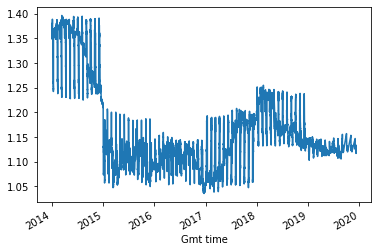

In [8]:
# Hourly EUR to USD exchange rates
df.Rate.plot()

In [9]:
# Hourly percentage changes in exchange rate (resampled to daily)
df['Return'] = df.Rate.pct_change() * 100 * 24
df = df.resample('D').mean()
df = df.dropna()
df.head()

,Rate,Return
Gmt time,,
2014-01-01,1.374557,0.167748
2014-01-02,1.348635,-0.006302
2014-01-03,1.380160,-0.001811
2014-01-04,1.378907,0.141308
2014-01-05,1.387214,0.014192


<AxesSubplot:xlabel='Gmt time'>

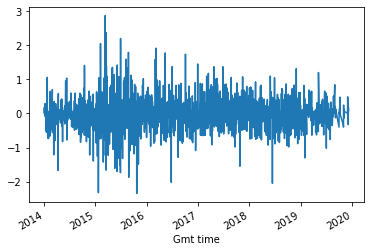

In [10]:
df.Return.plot()

# GARCH

In [11]:
from arch import arch_model

In [12]:
# Create the GARCH model
model = arch_model(df.Return, mean="Zero", vol="GARCH", p=2, q=2)
results = model.fit(disp="off")

In [13]:
# Output the model summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1096.83
Distribution:                  Normal   AIC:                           2203.66
Method:            Maximum Likelihood   BIC:                           2231.82
                                        No. Observations:                 2062
Date:                Mon, Mar 22 2021   Df Residuals:                     2062
Time:                        19:24:41   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.1420e-03  1.794e-02  6.367e-02      0.949 [-3.401e-02,3.629e-02]
alpha[1]       0.0241      0.523  4.616e-02      0.963      [ -1.000,  1.048]
alpha[2]   1.4466e-13      0.921  1.571e-13      1.000      [ -1.805,  1.805]
beta[1]        0.3907     22.396  1.745e-02      0.986      [-43.505, 44.287]
beta[2]        0.5789     21.906  2.643e-02      0.979      [-42.355, 43.513]
=============================================================================

Covariance estimator: robust
"""

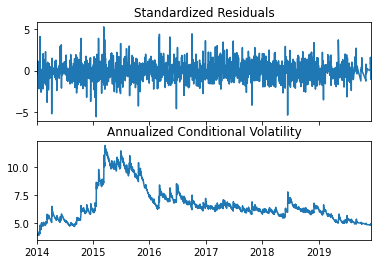

In [14]:
# Plot the model estimate of the annualized volatility
fig = results.plot(annualize='D')

# Forecasting from GARCH

In [15]:
# Find the last day of the dataset
last_day = df.index.max().strftime('%Y-%m-%d')
last_day

'2019-12-08'

In [16]:
# Create a 5 day forecast of EUR to USD exchange rate volatility
forecast_horizon = 5
# Take the last day of the data we used above. 
# If forecast horizon is 3, then the resulting 'h.1', 'h.2', and 'h.3' 
# are the forecasts for the following 3 days.
forecasts = results.forecast(start=last_day, horizon=forecast_horizon)

C:\Users\email\Anaconda3\envs\dev\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


In [17]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Gmt time,,,,,
2019-12-08,4.86332,4.877845,4.883856,4.894722,4.902688


# Visualizing the forecast

In [18]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Gmt time,2019-12-08
h.1,4.863320
h.2,4.877845
h.3,4.883856
h.4,4.894722
h.5,4.902688


<AxesSubplot:title={'center':'5 Day Exchange Rate Forecast of Volatility'}>

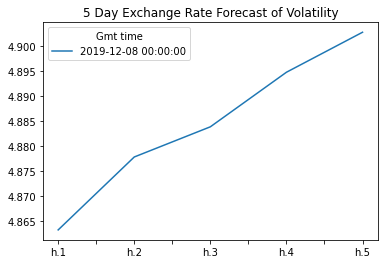

In [19]:
# Plot the final forecast
final.plot(title="5 Day Exchange Rate Forecast of Volatility")

Question: Is the exchange rate risk expected to increase or decrease over the next 5 days?

Answer: Based on the upward trend in the forecast plot, the exchange rate risk is expected to increase.